In [1]:
#%config Completer.use_jedi = False

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

%matplotlib inline

# Set up GPU

In [1]:
! nvidia-smi

Tue Jun 28 19:03:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN RTX    Off  | 00000000:06:00.0 Off |                  N/A |
| 41%   26C    P8    12W / 280W |      0MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA TITAN RTX    Off  | 00000000:07:00.0 Off |                  N/A |
| 41%   

In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

no_cuda = False
device = torch.device("cuda" if torch.cuda.is_available() and not no_cuda else "cpu") # defult setting
n_gpu = torch.cuda.device_count() # n_gpu = 0
n_gpu

1

# Inport data

In [6]:
df = pd.read_csv('Spam Email raw text for NLP.csv')
df.head(5)

,CATEGORY,MESSAGE,FILE_NAME
0,1,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",00249.5f45607c1bffe89f60ba1ec9f878039a
1,1,ATTENTION: This is a MUST for ALL Computer Use...,00373.ebe8670ac56b04125c25100a36ab0510
2,1,This is a multi-part message in MIME format.\n...,00214.1367039e50dc6b7adb0f2aa8aba83216
3,1,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,00210.050ffd105bd4e006771ee63cabc59978
4,1,This is the bottom line. If you can GIVE AWAY...,00033.9babb58d9298daa2963d4f514193d7d6


/home/hgong12/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='CATEGORY', ylabel='count'>

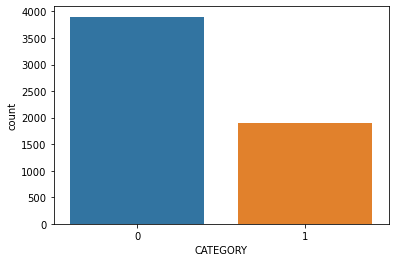

In [7]:
sns.countplot(df['CATEGORY'])

# Text cleaning

In [8]:
def standardize_text(df, content_field):
    df[content_field] = df[content_field].str.replace(r"http\S+", "")
    df[content_field] = df[content_field].str.replace(r"http", "")
    df[content_field] = df[content_field].str.replace(r"@\S+", "")
    df[content_field] = df[content_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[content_field] = df[content_field].str.replace(r"@", "at")
    df[content_field] = df[content_field].str.lower()
    return df

In [9]:
standardize_text(df,"MESSAGE")

<ipython-input-8-0bf6e993cd07>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df[content_field] = df[content_field].str.replace(r"http\S+", "")
<ipython-input-8-0bf6e993cd07>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df[content_field] = df[content_field].str.replace(r"@\S+", "")
<ipython-input-8-0bf6e993cd07>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df[content_field] = df[content_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")


,CATEGORY,MESSAGE,FILE_NAME
0,1,"dear homeowner,\n\n \n\ninterest rates are at ...",00249.5f45607c1bffe89f60ba1ec9f878039a
1,1,attention this is a must for all computer use...,00373.ebe8670ac56b04125c25100a36ab0510
2,1,this is a multi part message in mime format \n...,00214.1367039e50dc6b7adb0f2aa8aba83216
3,1,important information \n\n\n\nthe new domain n...,00210.050ffd105bd4e006771ee63cabc59978
4,1,this is the bottom line if you can give away...,00033.9babb58d9298daa2963d4f514193d7d6
...,...,...,...
5791,0,"i'm one of the 30,000 but it's not working ver...",00609.dd49926ce94a1ea328cce9b62825bc97
5792,0,damien morton quoted \n\n w3c approves html 4 ...,00957.e0b56b117f3ec5f85e432a9d2a47801f
5793,0,"on mon, 2002 07 22 at 06 50, che wrote \n\n\n\...",01127.841233b48eceb74a825417d8d918abf8
5794,0,"once upon a time, manfred wrote \n\n\n\n i w...",01178.5c977dff972cd6eef64d4173b90307f0


In [12]:
import re
import nltk
nltk.download("stopwords")
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hgong12/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hgong12/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [13]:
lemmatizer = WordNetLemmatizer()
corpus = []

for i in range(0, len(df)):
    message = re.sub('[^a-zA-Z]', ' ', df['MESSAGE'][i])
    message = message.split()
    message =[word for word in message if not word in set(stopwords.words('english'))]
    message = [lemmatizer.lemmatize(word) for word in message]
    message = ' '.join(message)
    corpus.append(message)

In [14]:
corpus[0]

'dear homeowner interest rate lowest point year help find best rate situation matching need hundred lender home improvement refinance second mortgage home equity loan even le perfect credit service free home owner new home buyer without obligation fill quick simple form jump start future plan today visit unsubscribe please visit'

# Train-test split

In [114]:
y = df["CATEGORY"]

In [115]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(corpus, y, test_size=0.2, random_state=42)

In [116]:
len(X_train), len(X_test)

(4636, 1160)

# BERT model feature extraction

In [19]:
from transformers import BertTokenizer, BertModel, BertConfig
import torch

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)
model = BertModel.from_pretrained("bert-base-uncased", config=config)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Training set

In [20]:
df_train = pd.DataFrame()
df_train['category'] = y_train
df_train.reset_index(drop=True, inplace=True)
df_train['id'] = [i for i in range(len(df_train))]
df_train['text'] = X_train

In [21]:
df_train['input_ids'] = df_train['text'].apply(lambda x: tokenizer(x)['input_ids'][1:-1])
df_train['len'] = df_train['input_ids'].apply(lambda x: len(x))

Token indices sequence length is longer than the specified maximum sequence length for this model (1200 > 512). Running this sequence through the model will result in indexing errors


In [22]:
df_train.head(5)

,category,id,text,input_ids,len
0,0,0,j joseph barrera joseph writes j fine fork pie...,"[1046, 3312, 23189, 2527, 3312, 7009, 1046, 29...",59
1,1,1,dear friend mr sese seko widow late president ...,"[6203, 2767, 2720, 7367, 3366, 7367, 3683, 779...",264
2,1,2,dear zzzz c cbody bgcolor ffccff e ctable bord...,"[6203, 1062, 13213, 2480, 1039, 17324, 7716, 2...",1198
3,1,3,insight news alert new issue insight news onli...,"[12369, 2739, 9499, 2047, 3277, 12369, 2739, 3...",459
4,0,4,use perl daily headline mailer damian conway p...,"[2224, 2566, 2140, 3679, 17653, 5653, 2121, 19...",63


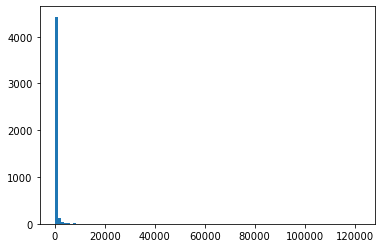

In [23]:
plt.hist(df_train['len'], bins=100)
plt.show()

In [24]:
# chrunk 510 length of tokens (overlapping length can be adjusted)
def truncate(df, trunk_len=510, overlap_len=0):
    want = pd.DataFrame({'id':[], 'input_ids_trunc':[]})
    for i in range(len(df)):
        length = df['len'][i]
        n = int(np.ceil(length/(trunk_len-overlap_len)))
        for j in range(n):
            tok = [101]
            tok += df['input_ids'][i][j*(trunk_len-overlap_len): 
                                 j*(trunk_len-overlap_len)+trunk_len]
            tok += [102]
            want = want.append({
                'input_ids_trunc': tok,
                'id': df['id'][i]}, ignore_index=True)
    return want

In [25]:
df_train_trunked = truncate(df_train, trunk_len=510, overlap_len=110)
df_train_trunked['len'] = df_train_trunked['input_ids_trunc'].apply(lambda x: len(x))
df_train_trunked['id'] = df_train_trunked['id'].apply(lambda x: int(x))

In [136]:
def get_cls_output_list_gpu(df_train_trunked):
    model.to(device)
    model.eval()
    
    cls_output_list = []
    for i in tqdm(range(len(df_train_trunked))):
        input_ids = df_train_trunked['input_ids_trunc'][i]
        token_type_ids = [0] * len(input_ids)
        attention_mask = [1] * len(input_ids)

        input_ids = torch.tensor([input_ids]).to(device)
        token_type_ids = torch.tensor([token_type_ids]).to(device)
        attention_mask = torch.tensor([attention_mask]).to(device)
        
        with torch.no_grad():
        # model(**input_dict) is the output
        # output[0] is the last hidden states, get another [0] is reducing dimension
        # cls_output is the first token
            cls_output = model(input_ids, token_type_ids, attention_mask)[0][0][0].cpu().numpy()
            cls_output_list.append(cls_output)
        
    return cls_output_list
# how to get the last hidden state from BERT 
# https://github.com/huggingface/transformers/issues/1827

In [37]:
def get_cls_output_list_cpu(df_train_trunked):
    cls_output_list = []
    for i in tqdm(range(len(df_train_trunked))):
        input_ids = df_train_trunked['input_ids_trunc'][i]
        token_type_ids = [0] * len(input_ids)
        attention_mask = [1] * len(input_ids)

        input_dict = {}
        input_dict['input_ids'] = torch.tensor([input_ids])
        input_dict['token_type_ids'] = torch.tensor([token_type_ids])
        input_dict['attention_mask'] = torch.tensor([attention_mask])
        
        # model(**input_dict) is the output
        # output[0] is the last hidden states, get another [0] is reducing dimension
        # cls_output is the first token
        cls_output = model(**input_dict)[0][0][0].numpy()
        cls_output_list.append(cls_output)
        
    return cls_output_list
# how to get the last hidden state from BERT 
# https://github.com/huggingface/transformers/issues/1827

In [137]:
cls_output_list = get_cls_output_list_gpu(df_train_trunked)

100%|██████████| 8042/8042 [01:45<00:00, 76.19it/s]


In [138]:
df_train_trunked['cls_output'] = cls_output_list

In [139]:
df_train_trunked.head(5)

,id,input_ids_trunc,len,cls_output
0,0,"[101, 1046, 3312, 23189, 2527, 3312, 7009, 104...",61,"[-0.25802734, 0.459538, 0.18791308, 0.18568842..."
1,1,"[101, 6203, 2767, 2720, 7367, 3366, 7367, 3683...",266,"[-0.492636, 0.2851513, 0.41103062, -0.0676382,..."
2,2,"[101, 6203, 1062, 13213, 2480, 1039, 17324, 77...",512,"[-0.64157665, 0.038553566, 0.40967038, 0.14246..."
3,2,"[101, 1041, 12935, 12162, 3609, 21461, 25212, ...",512,"[-1.0326445, 0.1232555, 0.2323305, 0.21684843,..."
4,2,"[101, 1038, 1050, 5910, 2361, 1038, 1050, 5910...",400,"[-0.9115936, 0.2063725, -0.28147653, 0.3136617..."


In [140]:
# get max pooling for each ID
keys = np.array(df_train_trunked['id'])
vals = np.asarray(cls_output_list)
array_grouped_dict_train = {key: vals[keys == key] for key in np.unique(keys)}
for key in array_grouped_dict_train:
    array_grouped_dict_train[key] = array_grouped_dict_train[key].mean(axis=0)

In [141]:
df_train['vector'] = df_train['id'].map(array_grouped_dict_train)

In [142]:
df_train.head(5)

,category,id,text,input_ids,len,vector
0,0,0,j joseph barrera joseph writes j fine fork pie...,"[1046, 3312, 23189, 2527, 3312, 7009, 1046, 29...",59,"[-0.25802734, 0.459538, 0.18791308, 0.18568842..."
1,1,1,dear friend mr sese seko widow late president ...,"[6203, 2767, 2720, 7367, 3366, 7367, 3683, 779...",264,"[-0.492636, 0.2851513, 0.41103062, -0.0676382,..."
2,1,2,dear zzzz c cbody bgcolor ffccff e ctable bord...,"[6203, 1062, 13213, 2480, 1039, 17324, 7716, 2...",1198,"[-0.86193824, 0.122727185, 0.120174795, 0.2243..."
3,1,3,insight news alert new issue insight news onli...,"[12369, 2739, 9499, 2047, 3277, 12369, 2739, 3...",459,"[-0.38687897, -0.046124548, 0.041686356, 0.058..."
4,0,4,use perl daily headline mailer damian conway p...,"[2224, 2566, 2140, 3679, 17653, 5653, 2121, 19...",63,"[-0.19225617, 0.049564634, -0.41233602, -0.067..."


## Testing set

In [117]:
df_test = pd.DataFrame()
df_test['category'] = y_test
df_test.reset_index(drop=True, inplace=True)
df_test['id'] = [i for i in range(len(df_test))]
df_test['text'] = X_test

In [118]:
df_test['input_ids'] = df_test['text'].apply(lambda x: tokenizer(x)['input_ids'][1:-1])
df_test['len'] = df_test['input_ids'].apply(lambda x: len(x))

In [119]:
df_test.head(5)

,category,id,text,input_ids,len
0,0,0,could try httrack available recursive grab stu...,"[2071, 3046, 1044, 4779, 22648, 2243, 2800, 28...",32
1,0,1,adam l beberg wrote creator didnt say could wi...,"[4205, 1048, 2022, 4059, 2626, 8543, 2134, 210...",130
2,0,2,gary lawrence murphy wrote say hello cool oooo...,"[5639, 5623, 7104, 2626, 2360, 7592, 4658, 105...",233
3,0,3,wasnt even though spellingis oddly familar new...,"[2347, 2102, 2130, 2295, 11379, 2483, 15056, 6...",146
4,0,4,gary murphy intend take legal violent action p...,"[5639, 7104, 13566, 2202, 3423, 6355, 2895, 21...",210


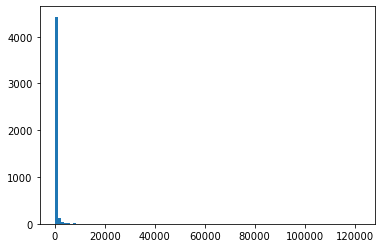

In [120]:
plt.hist(df_train['len'], bins=100)
plt.show()

In [121]:
df_test_trunked = truncate(df_test, trunk_len=510, overlap_len=110)
df_test_trunked['len'] = df_test_trunked['input_ids_trunc'].apply(lambda x: len(x))
df_test_trunked['id'] = df_test_trunked['id'].apply(lambda x: int(x))

In [143]:
cls_output_list = get_cls_output_list_gpu(df_test_trunked)

100%|██████████| 1846/1846 [00:24<00:00, 76.27it/s]


In [144]:
df_test_trunked['cls_output'] = cls_output_list

In [145]:
df_test_trunked.head(5)

,id,input_ids_trunc,len,cls_output
0,0,"[101, 2071, 3046, 1044, 4779, 22648, 2243, 280...",34,"[-0.44594392, 0.06953239, 0.046528567, 0.40067..."
1,1,"[101, 4205, 1048, 2022, 4059, 2626, 8543, 2134...",132,"[-0.07137385, 0.1835863, 0.37147498, 0.2137879..."
2,2,"[101, 5639, 5623, 7104, 2626, 2360, 7592, 4658...",235,"[-0.52994, 0.16760735, 0.36706507, 0.23636337,..."
3,3,"[101, 2347, 2102, 2130, 2295, 11379, 2483, 150...",148,"[-0.5394836, 0.22984922, 0.32722324, 0.0394827..."
4,4,"[101, 5639, 7104, 13566, 2202, 3423, 6355, 289...",212,"[-0.39268383, 0.33426964, 0.44466457, -0.14385..."


In [146]:
# get max pooling for each ID
keys = np.array(df_test_trunked['id'])
vals = np.asarray(cls_output_list)
array_grouped_dict_test = {key: vals[keys == key] for key in np.unique(keys)}
for key in array_grouped_dict_test:
    array_grouped_dict_test[key] = array_grouped_dict_test[key].mean(axis=0)

In [147]:
df_test['vector'] = df_test['id'].map(array_grouped_dict_train)

In [148]:
df_test.head(5)

,category,id,text,input_ids,len,vector
0,0,0,could try httrack available recursive grab stu...,"[2071, 3046, 1044, 4779, 22648, 2243, 2800, 28...",32,"[-0.25802734, 0.459538, 0.18791308, 0.18568842..."
1,0,1,adam l beberg wrote creator didnt say could wi...,"[4205, 1048, 2022, 4059, 2626, 8543, 2134, 210...",130,"[-0.492636, 0.2851513, 0.41103062, -0.0676382,..."
2,0,2,gary lawrence murphy wrote say hello cool oooo...,"[5639, 5623, 7104, 2626, 2360, 7592, 4658, 105...",233,"[-0.86193824, 0.122727185, 0.120174795, 0.2243..."
3,0,3,wasnt even though spellingis oddly familar new...,"[2347, 2102, 2130, 2295, 11379, 2483, 15056, 6...",146,"[-0.38687897, -0.046124548, 0.041686356, 0.058..."
4,0,4,gary murphy intend take legal violent action p...,"[5639, 7104, 13566, 2202, 3423, 6355, 2895, 21...",210,"[-0.19225617, 0.049564634, -0.41233602, -0.067..."


# Logistic Regression

In [149]:
# training data
X = torch.tensor(list(df_train['vector'].values) )
y = torch.tensor(list(df_train['category'].values)).float()

In [150]:
# testing data
X_test = torch.tensor(list(df_test['vector'].values) )
y_test = torch.tensor(list(df_test['category'].values)).float()

In [151]:
print (len(X))
print (len(y))
print (len(X_test))
print (len(y_test))

4636
4636
1160
1160


In [152]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
logit = LogisticRegression(C=5e1, solver='lbfgs', random_state=17, n_jobs=4)

In [153]:
%%time
logit.fit(X, y)

CPU times: user 26.8 ms, sys: 108 ms, total: 135 ms
Wall time: 5.49 s


LogisticRegression(C=50.0, n_jobs=4, random_state=17)

In [154]:
y_pred = logit.predict(X_test)
y_pred_proba = logit.predict_proba(X_test)[:,1]

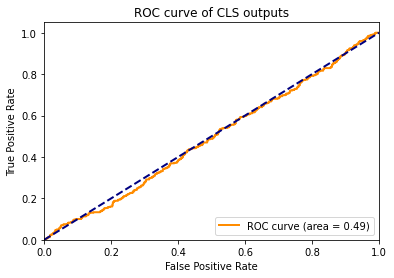

In [157]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from matplotlib import pyplot
import sklearn.metrics as metrics
%matplotlib inline

# Compute ROC curve and ROC area for each class

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of CLS outputs')
plt.legend(loc="lower right")
plt.show()

In [156]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_pred))) 
print('F1: {0:.2f}'.format(f1_score(y_test, y_pred))) 
print('Recall: {0:.2f}'.format(recall_score(y_test, y_pred)))

Accuracy: 0.54
Precision: 0.33
F1: 0.34
Recall: 0.34
